## Импорты, функции из занятия

In [32]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

from itertools import chain, product

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [59]:
def plot_manifold(latent_r, labels=None, alpha=0.9, classes=None):
    plt.figure(figsize=(10, 10))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], cmap="tab10", alpha=alpha)
    else:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha)
        cbar = plt.colorbar()
    if classes:
        cbar.ax.set_yticklabels(classes)
    plt.show()


# plotting reconstructed and noised images
def plot_samples(*args, invert_colors=True, digit_size=28, name=None):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * digit_size : (j + 1) * digit_size,
                i * digit_size : (i + 1) * digit_size,
            ] = args[j][i].squeeze()

    if invert_colors:
        figure = 1 - figure

    plt.figure(figsize=(2 * n, 2 * len(args)))
    plt.imshow(figure, cmap="Greys_r", clim=(0, 1))

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()


def train(
    encoder,
    decoder,
    loader,
    optimizer,
    single_pass_handler,
    loss_handler,
    epoch,
    log_interval=500,
):
    for batch_idx, (data, lab) in enumerate(loader):
        batch_size = data.size(0)
        optimizer.zero_grad()
        data = data.to(device)
        lab = lab.to(device)

        latent, output = single_pass_handler(encoder, decoder, data, lab)

        loss = loss_handler(data, output, latent)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(loader.dataset),
                    100.0 * batch_idx / len(loader),
                    loss.item(),
                )
            )


# return reconstructed image, use to compute loss
def ae_pass_handler(encoder, decoder, data, *args, **kwargs):
    latent = encoder(data)
    recons = decoder(latent)
    return latent, recons


# loss function
def ae_loss_handler(data, recons, *args, **kwargs):
    return F.binary_cross_entropy(recons, data)


# return result in numpy to visualization
def run_eval(
    encoder,
    decoder,
    loader,
    single_pass_handler,
    return_real=True,
    return_recontr=True,
    return_latent=True,
    return_labels=True,
):

    if return_real:
        real = []
    if return_recontr:
        reconstr = []
    if return_latent:
        latent = []
    if return_labels:
        labels = []
    with torch.no_grad():
        for batch_idx, (data, lab) in enumerate(loader):
            if return_labels:
                labels.append(lab.numpy())
            if return_real:
                real.append(data.numpy())

            data = data.to(device)
            lab = lab.to(device)
            rep, rec = single_pass_handler(encoder, decoder, data, lab)
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recontr:
                reconstr.append(rec.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result["latent"] = latent
    if return_recontr:
        reconstr = np.concatenate(reconstr)
        result["reconstr"] = reconstr.squeeze()
    if return_labels:
        labels = np.concatenate(labels)
        result["labels"] = labels
    return result

In [60]:
import torch.nn as nn

# autoencoder model
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size
        hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        modules = []
        in_channels = 1
        for h_dim in hidden_dims[:-1]:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=h_dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim

        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(),
            )
        )
        modules.append(nn.Flatten())
        modules.append(nn.Linear(hidden_dims[-1] * 4, latent_size))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        hidden_dims = [512, 256, 128, 64, 32]
        self.linear = nn.Linear(in_features=latent_size, out_features=hidden_dims[0])

        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    hidden_dims[-1],
                    hidden_dims[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(),
                nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=7, padding=1),
                nn.Sigmoid(),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 512, 1, 1)
        x = self.decoder(x)
        return x

# Задание 1. Автоэнкодер для FashionMNIST c MSE-loss

В этом задании обучайте автоэнкодер на датасете FashionMNIST:

* Используйте энкодер и декодер из лекции (код `Encoder`, `Decoder` выше).
* Не переопределяя класс уберите из декодера сигмоиду в конце.
* Используйте MSE-loss между реальным и восстановленным изображением (обратите внимание на количество входов `ae_loss_handler` функции и `F.mse_loss` функции).
* Обучите автоэнкодер с размером латентного слоя 2.

Как выглядит латентное представление?

Разделяются ли в нем классы?

Далее:

*   Обучите автоэнкодер с размером латентного слоя 30
*   Продемонстрируйте восстановление автоэнкодером переданных ему изображений

Напишите вывод.

**Подсказка:**

* для обучения  можете использовать функцию `train` (код выше),
* для получения исходных картинок, восстановленных картинок, латентного представления можете использовать функцию `run_eval` (код выше),
* не забудьте перевести модель в тестовый режим,
* для визуализации латентного пространства можете использовать функцию `plot_manifold` (код выше),
* для визуализации восстановления изображений можете использовать функцию `plot_samples` (код выше).

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

root = "./data"

base = transforms.ToTensor()
train_set = FashionMNIST(root=root, train=True, transform=base, download=True)
test_set = FashionMNIST(root=root, train=False, transform=base, download=True)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

В датасете 10 классов, каждый соответствует одному из предметов гардероба.

In [7]:
import numpy as np

# method for display all class samples from dataset
def show_ds(ds):
    fig, axs = plt.subplots(1, len(ds.classes), figsize=(20, 5))
    for cls_num, name in enumerate(ds.classes):
        i = np.argwhere(ds.targets == cls_num)[0][0]
        inverted = 255 - ds.data[i]
        ax = axs[cls_num]
        ax.imshow(inverted, cmap="Greys_r")
        ax.set_title(name)
        ax.axis("off")
    plt.show()

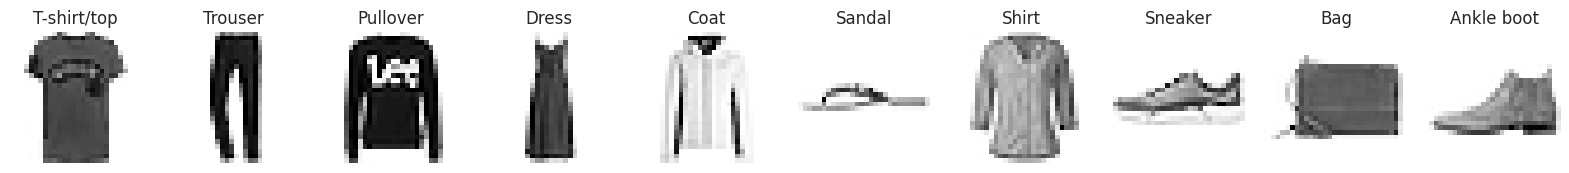

In [ ]:
show_ds(test_set)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
latent_dim = 2
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)

In [ ]:
import torch.optim as optim
from itertools import chain
def mse_loss_handler(data, recons, *args, **kwargs):
    return nn.MSELoss()(recons, data)
torch.manual_seed(42)
latent_size = latent_dim
decoder.decoder[-1][-1] = nn.Identity()
learning_rate = 0.001

optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=learning_rate)
from torchsummary import summary
print('>>> Encoder')
print(summary(encoder, (1, 28, 28)))
print('>>> Decoder')
print(summary(decoder, (1, latent_size)))


>>> Encoder
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
       BatchNorm2d-2           [-1, 32, 14, 14]              64
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,496
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
        LeakyReLU-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 512, 2, 2]         131,584
      BatchNorm2d-14       

In [ ]:
for i in range(1, 6):
    train(
        encoder=encoder,
        decoder=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=ae_pass_handler,
        loss_handler=mse_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.257165
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.044280
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.036096
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.041479
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.037397
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.037116
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.034503
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.031675
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.033736
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.032808
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.030889
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.033064
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.028347
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.030215
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.027872
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.036144
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.030048
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.024462
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.031391
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.031102
Train Epoch:

In [ ]:
def single_pass_handler(encoder, decoder, data, labels):
    latent_representation = encoder(data)
    reconstructed = decoder(latent_representation)
    return latent_representation, reconstructed

In [ ]:
encoder.eval()
decoder.eval()
results0 = run_eval(encoder, decoder, test_loader, single_pass_handler)

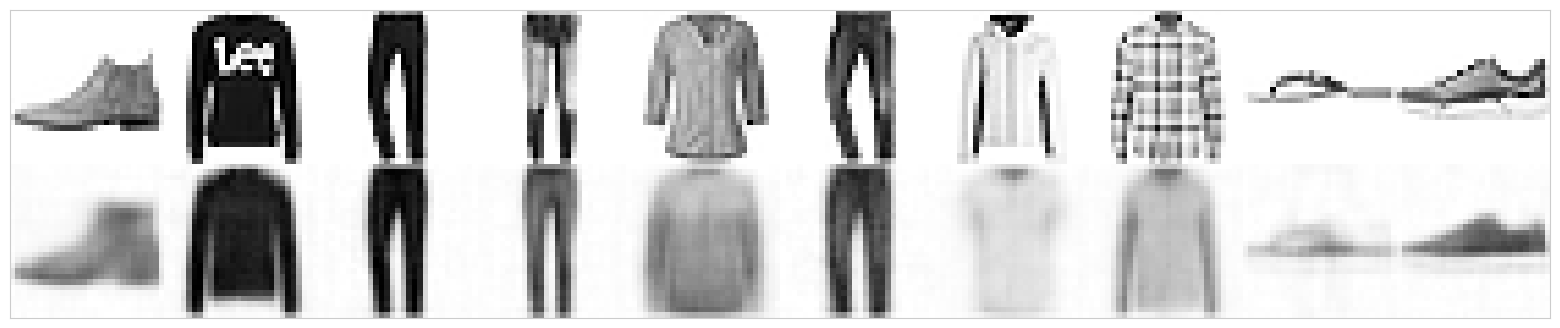

In [ ]:
plot_samples(results0["real"][:10], results0["reconstr"][:10], invert_colors=True, digit_size=28, name=None)

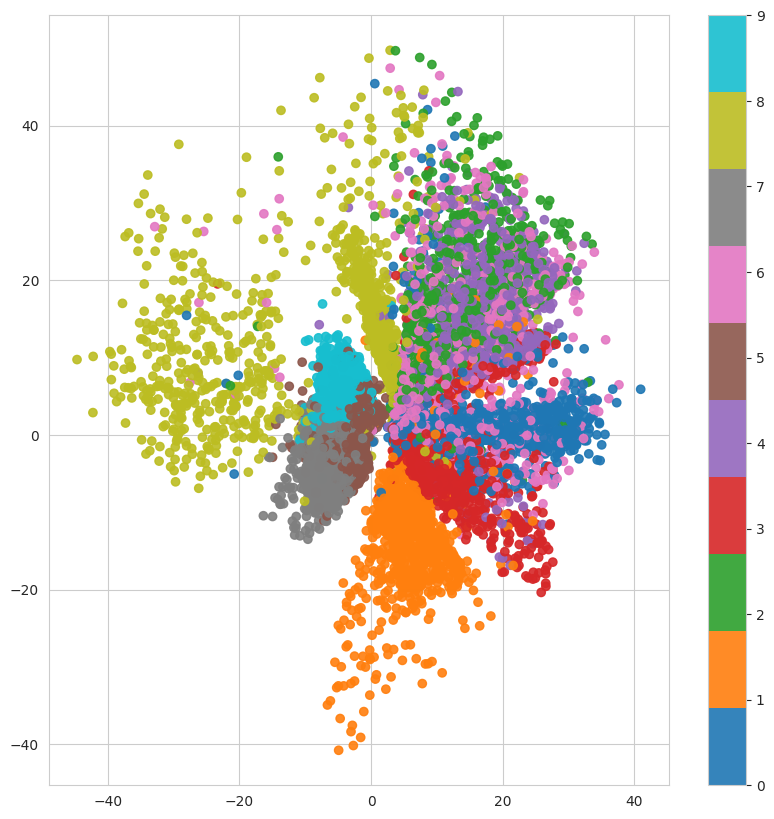

In [ ]:
plot_manifold(results0["latent"], labels=results0["labels"], alpha=0.9, classes=None)

latent_dim = 2 дает слишком нерепрезентативное распределение для клаасов одежды, так, например, класс t-shirt сильно смешивается со всеми остальными в латентном пространстве. Теперь поставим latent_dim = 30 и сравним.

In [ ]:
latent_size = 30
encoder = Encoder(latent_size).to(device)
decoder = Decoder(latent_size).to(device)
decoder.decoder[-1][-1] = nn.Identity()
learning_rate = 0.001

optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=learning_rate)

from torchsummary import summary
print('>>> Encoder')
print(summary(encoder, (1, 28, 28)))
print('>>> Decoder')
print(summary(decoder, (1, latent_size)))


>>> Encoder
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
       BatchNorm2d-2           [-1, 32, 14, 14]              64
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,496
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
        LeakyReLU-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 512, 2, 2]         131,584
      BatchNorm2d-14       

In [ ]:
for i in range(1, 6):
    train(
        encoder=encoder,
        decoder=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=ae_pass_handler,
        loss_handler=mse_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.287935
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.040025
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.034027
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.023507
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.021738
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.023207
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.018108
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.019085
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.017206
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.018496
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.018885
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.013791
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.013501
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.012643
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.014509
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.013279
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.014514
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.014034
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.011765
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.013988
Train Epoch:

In [ ]:
encoder.eval()
decoder.eval()
results1 = run_eval(encoder, decoder, test_loader, single_pass_handler)

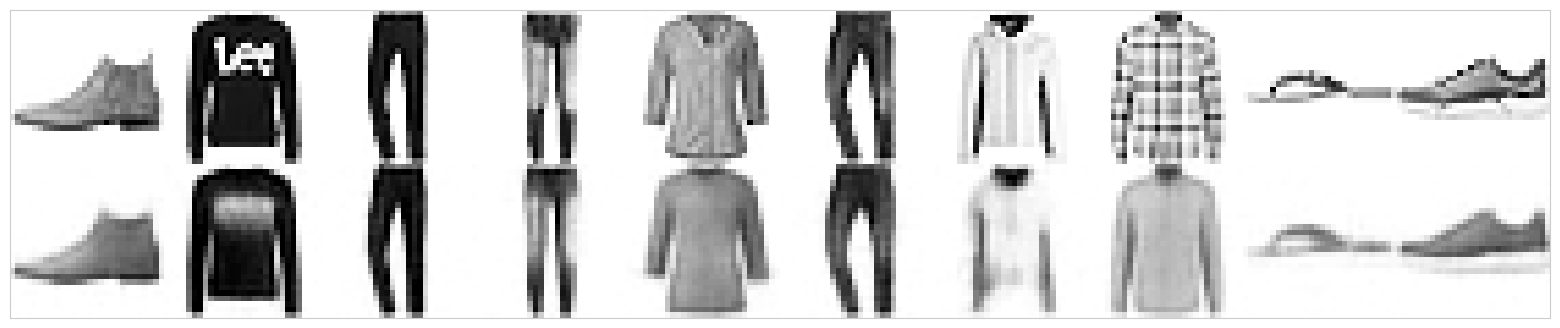

In [ ]:
plot_samples(results1["real"][:10], results1["reconstr"][:10], invert_colors=True, digit_size=28, name=None)

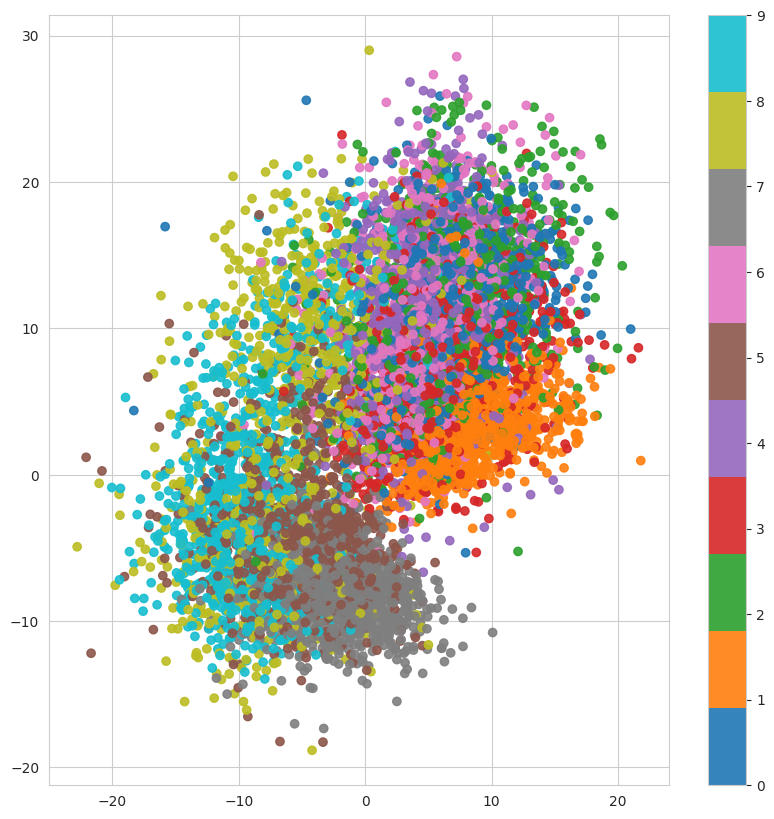

In [ ]:
plot_manifold(results1["latent"], labels=results1["labels"], alpha=0.9, classes=None)

Восстановленные изображения часто становятся размытими из-за потери мелких деталей, поскольку модель фокусируется на главных признаках. При повышении размерности скрытого представления увеличивается способность модели запоминать более сложные паттерны, но это не всегда означает, что она учитывает все детали. Модель может игнорировать мелкие элементы, рассматривая их как шум, что влияет на качество реконструкции.

## Формат результата

**Напишите вывод:**

Какие особенности есть у восстановленных изображений? Почему?
При повышении размерности скрытого представления качество реконструкции сэмплов заметно улучшается, т.к. теперь модель запоминает больше признаков от исходных изображений.
Хорошо видно, что после восстановления изображения становятся размытими и теряют мелкие детали. Это следствие того, что скрытое представление выучивает только главные признаки для сэмплов, игнорируя мелкие детали типо клеточек на рубашке, вороты, надписи на одежде и тп, считая их "шумом".

# Задание 2. Сэмплирование из обычного VAE

В случае с обычным VAE мы визуализировали только центры распределений, соответствувющих цифрам. Хотелось бы получить более полное представление о том, как выглядит латентное пространство.

Задача:
 1. Обучить VAE из лекции (`latent_size = 2`)
 2. Визуализировать латентные представления, который приходят на вход в `decoder`. Для этого можно воспользоваться функцией `plot_manifold`. Из каждого распределения, соответствующего объекту надо сэмплировать несколько раз (хотя бы 10). Чтобы точки на полученном графике не полностью перекрывались, используйте параметр `alpha` из `sns.scatterplot` или `plot_manifold` (код выше).

In [ ]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset

root = "./data"

train_set = MNIST(
    root=root, train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_set = MNIST(
    root=root, train=False, transform=torchvision.transforms.ToTensor(), download=True
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17632987.88it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 525242.79it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3833126.36it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7224318.84it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class VAEEncoder(Encoder):
    def __init__(self, latent_size):
        if latent_size % 2 != 0:
            raise Exception("Latent size for VAEEncoder must be even")
        super().__init__(latent_size)


def vae_split(latent):
    size = latent.shape[1] // 2
    mu = latent[:, :size]
    log_var = latent[:, size:]
    return mu, log_var


def vae_reparametrize(mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    z = torch.randn(mu.shape[0], mu.shape[1]).to(device)
    return z * sigma + mu


def vae_pass_handler(encoder, decoder, data, *args, **kwargs):
    latent = encoder(data)
    mu, log_var = vae_split(latent)
    sample = vae_reparametrize(mu, log_var)
    recons = decoder(sample)
    return latent, recons


def kld_loss(mu, log_var):
    var = log_var.exp()
    kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu**2 - var, dim=1), dim=0)
    return kl_loss


def vae_loss_handler(data, recons, latent, kld_weight=0.005, *args, **kwargs):
    mu, log_var = vae_split(latent)
    kl_loss = kld_loss(mu, log_var)
    ce_loss = F.binary_cross_entropy(recons, data)
    return kld_weight * kl_loss + ce_loss

In [ ]:
torch.manual_seed(42)

latent_dim = 2

learning_rate = 0.001
encoder = VAEEncoder(latent_size=latent_dim*2).to(device)
decoder = Decoder(latent_size=latent_dim).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

for i in range(1, 6):
    train(
        encoder=encoder,
        decoder=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=vae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.848170
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.245796
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.237574
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.226888
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.218229
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.229502
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.235019
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.235299
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.234579
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.219040
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.215599
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.210581
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.207486
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.215210
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.213854
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.226960
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.222376
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.213869
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.204816
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.206344
Train Epoch:

In [ ]:
encoder.eval()
decoder.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        latent = encoder(data)
        mu, log_var = vae_split(latent)
        break
var = np.exp(log_var.cpu().numpy())
print(var.shape)
# generate a new normal distribution from VAE for further plotting
norm_dist = torch.randn(var.shape)
new_dist = norm_dist*var + mu.cpu().numpy()
new_dist.shape

(64, 2)


torch.Size([64, 2])

In [ ]:
latents = []
labels = []

with torch.no_grad():
    for data, lab in test_loader:
        data = data.to(device)
        latent = encoder(data)
        mu, log_var = vae_split(latent)

        for m, lv, label in zip(mu, log_var, lab):
            for _ in range(10):
                sample = vae_reparametrize(m.unsqueeze(0), lv.unsqueeze(0))
                latents.append(sample.cpu().numpy())
                labels.append(label.item())

latents = np.array(latents)
labels = np.array(labels)

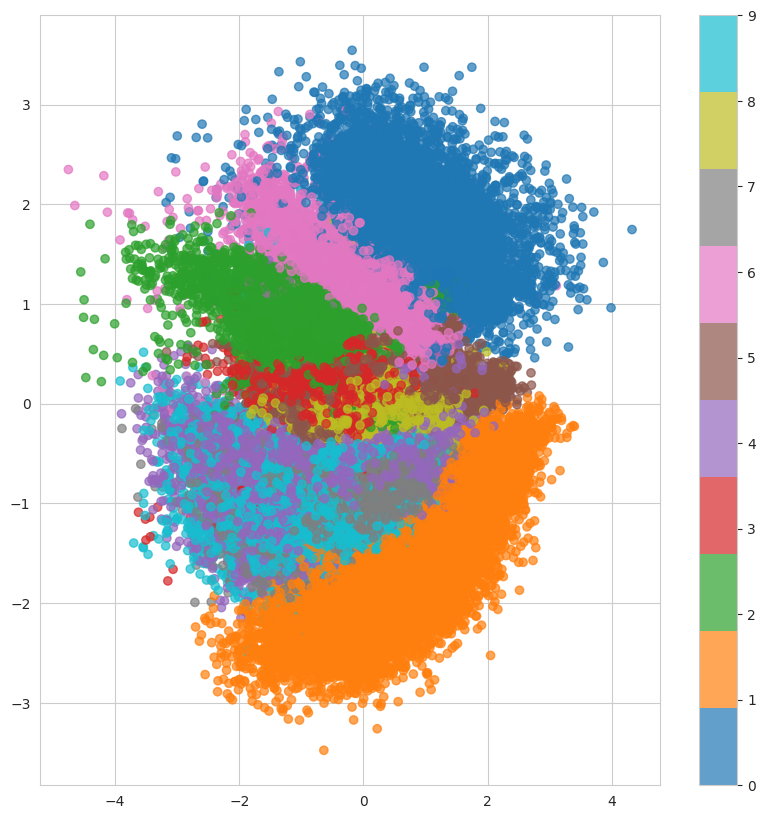

In [ ]:
plot_manifold(latents.reshape(-1, 2), labels=np.array(labels), alpha=0.7, classes=None)

Смотря на распределение цифр в латентном пр-ве, видно, что различимость классов в нем достаточно хорошая.

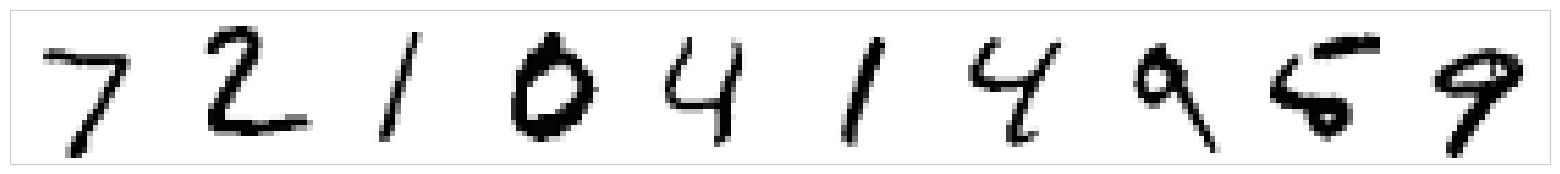

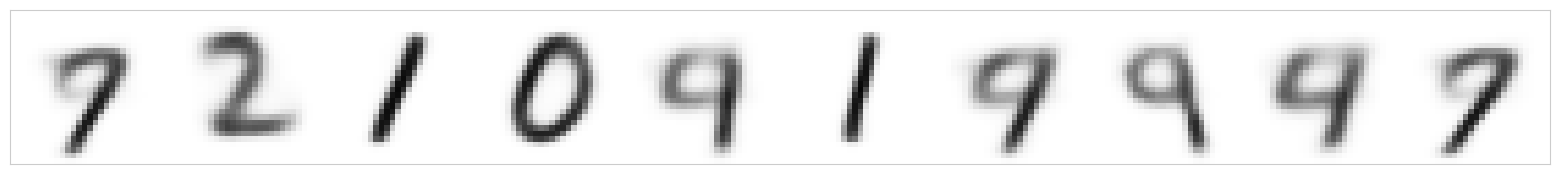

In [ ]:
plot_samples(data[:10].cpu().numpy(), invert_colors=True, digit_size=28, name=None)
with torch.no_grad():
    encoder.eval()
    decoder.eval()

    for data, _ in test_loader:
        data = data.to(device)
        latent = encoder(data)
        mu, log_var = vae_split(latent)
        sample = vae_reparametrize(mu, log_var)
        reconstructed = decoder(sample)

        plot_samples(reconstructed[:10].cpu().numpy(), invert_colors=True, digit_size=28, name=None)
        break

##  Визуализация латетного пространства


Для модели из предыдущего занятия, можно получить распределение классов цифр на плоскости, пример:



<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX14/vae_sampling.png" width="500">

Вашей задачей будет получить похожее изображение, используя модель из задания выше. Используйте побольше изображений в каждом ряду (скажем, 50). Иначе все цифры можете не увидеть

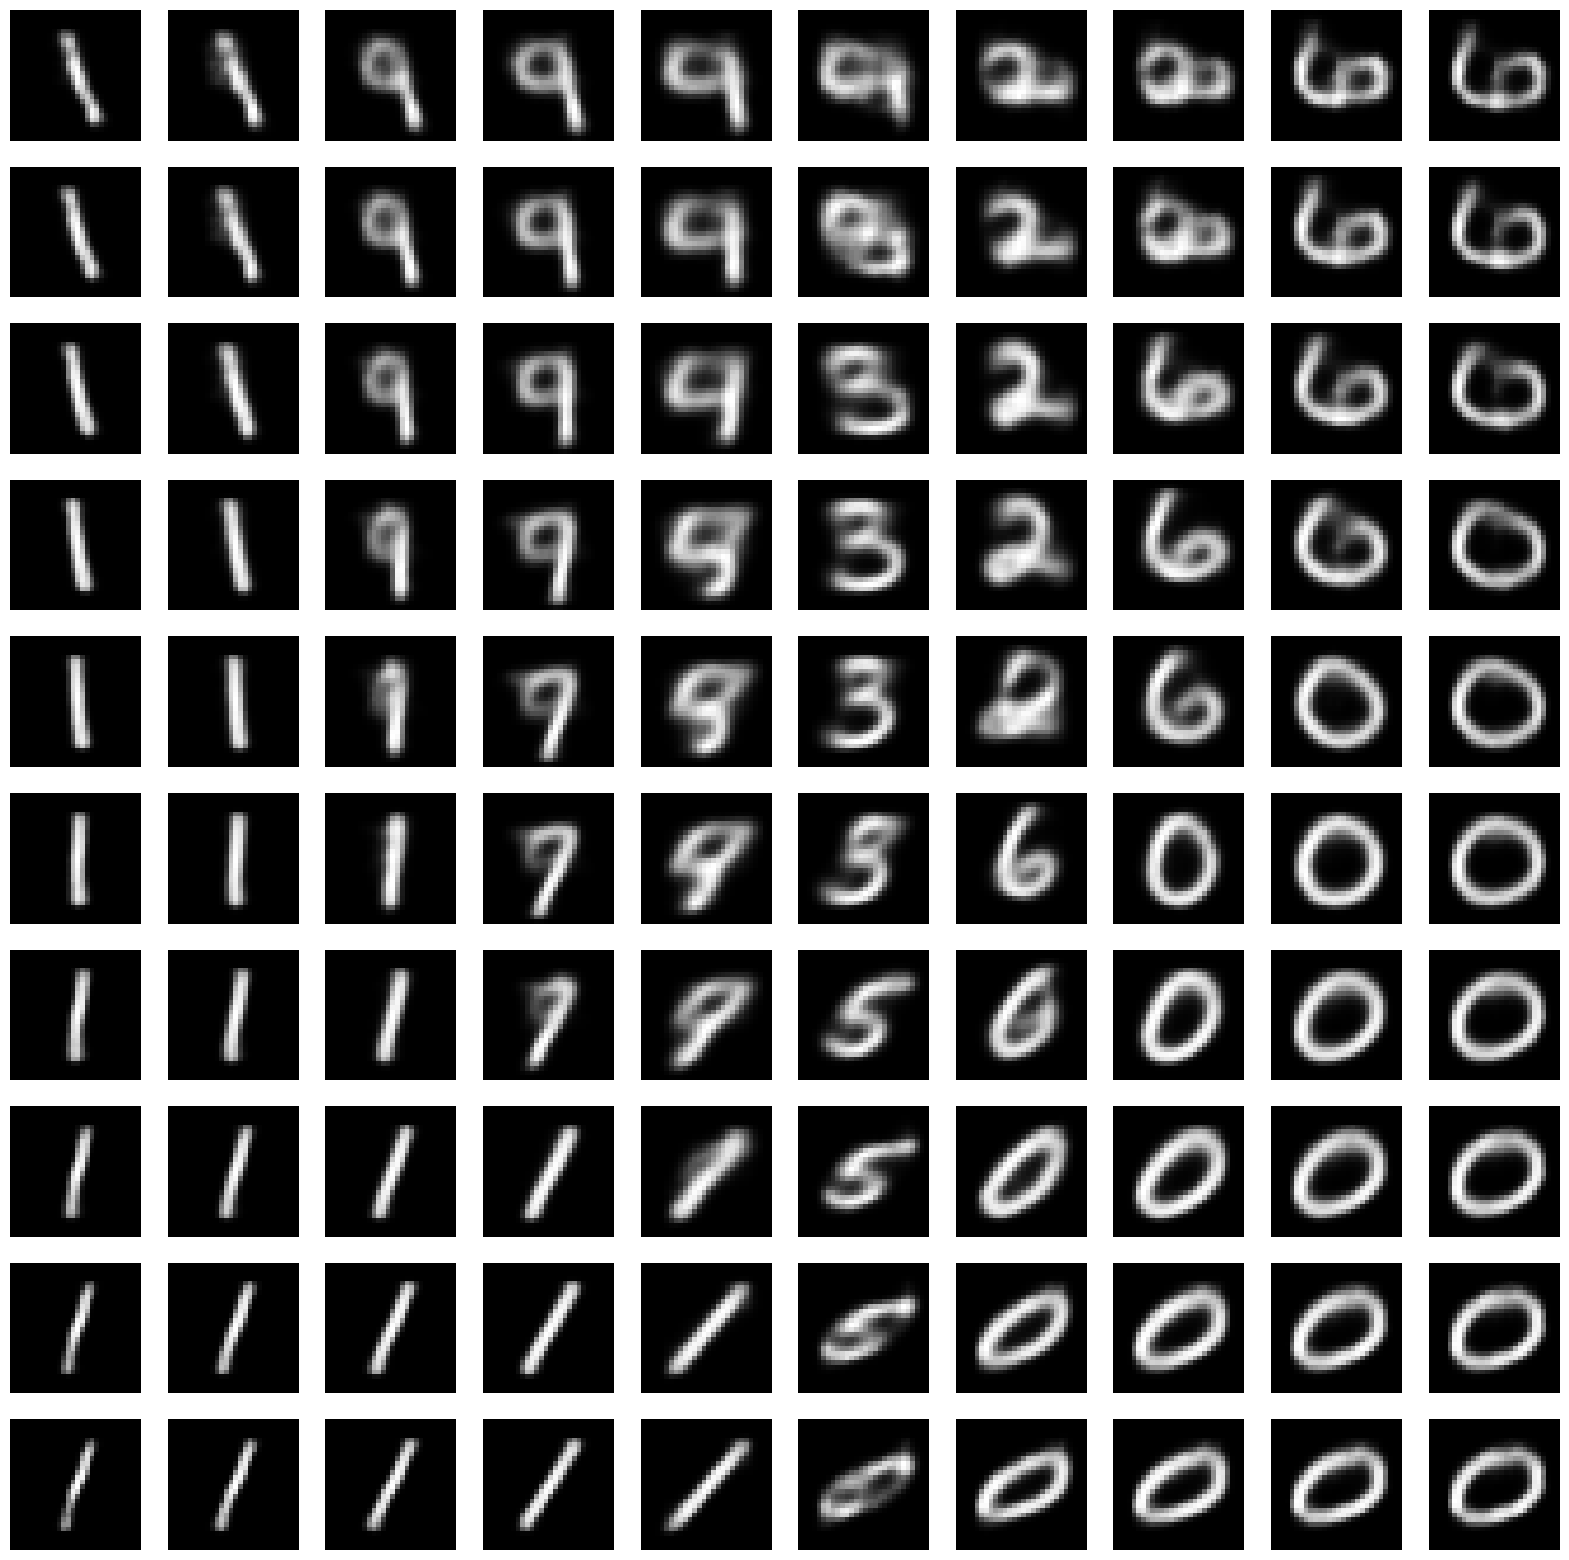

In [ ]:
import torch
import matplotlib.pyplot as plt

steps = 10
space1 = torch.linspace(-3, 3, steps).to(device)
space2 = torch.linspace(-3, 3, steps).to(device)

grid = torch.cartesian_prod(space1, space2)

with torch.no_grad():
    imgs = decoder(grid).cpu()

def plot_samples(imgs, images_per_row=10):
    num_images = imgs.shape[0]
    rows = (num_images + images_per_row - 1) // images_per_row

    plt.figure(figsize=(images_per_row * 2, rows * 2))

    for i in range(num_images):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(imgs[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')

    plt.show()

plot_samples(imgs, images_per_row=10)


Визуалихация скрытого пр-ва показывает вполне лгично перетекание одних цифр в другие.

# Задание 3. Перенос стиля при помощи CVAE



Обучите CVAE из лекции (`latent_size=2`)

Посмотрим на результат применения нескольких разных стилей семерки, для других цифр

Задача:

Реализовать визуализацию стилей тройки для других цифр

Для этого нужно выбрать 10 разных троек, желательно брать случайные 10 троек из датасета (`seed` зафиксируем)




In [ ]:
import torch
import torch.nn as nn

class CDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [512, 256, 128, 64, 32]
        self.linear = nn.Linear(
            in_features=latent_dim + 10, out_features=hidden_dims[0]
        )

        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    hidden_dims[-1],
                    hidden_dims[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(),
                nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=7, padding=1),
                nn.Sigmoid(),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x, lab):
        lab = lab.float()
        x = torch.cat([x, lab], dim=1)
        x = self.linear(x)
        x = x.view(x.size(0), -1, 1, 1)
        return self.decoder(x)
def cvae_pass_handler(encoder, decoder, data, label, *args, **kwargs):
    latent = encoder(data)
    mu, log_var = vae_split(latent)
    sample = vae_reparametrize(mu, log_var)
    label = torch.nn.functional.one_hot(label, num_classes=10) # labels to ohe
    recon = decoder(sample, label)
    return latent, recon

In [ ]:
torch.manual_seed(42)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)
latent_dim = 2

learning_rate = 0.001
encoder = VAEEncoder(latent_size=latent_dim*2).to(device)
decoder = CDecoder(latent_dim=latent_dim).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

for i in range(1, 6):
    train(
        encoder=encoder,
        decoder=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=cvae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.660079
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.212685
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.196575
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.195066
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.190571
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.188469
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.196213
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.180617
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.185384
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.195319
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.184272
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.184700
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.189585
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.191278
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.178913
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.185186
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.181652
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.184650
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.179389
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.189963
Train Epoch: 5 [0/60

In [ ]:
encoder.eval()
decoder.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        latent = encoder(data)
        mu, log_var = vae_split(latent)
        break
var = np.exp(log_var.cpu().numpy())
print(var.shape)
# generate a new normal distribution from VAE for further plotting
norm_dist = torch.randn(var.shape)
new_dist = norm_dist*var + mu.cpu().numpy()
new_dist.shape

(128, 2)


torch.Size([128, 2])

In [ ]:
latents = []
labels = []

with torch.no_grad():
    for data, lab in test_loader:
        data = data.to(device)
        latent = encoder(data)
        mu, log_var = vae_split(latent)

        for m, lv, label in zip(mu, log_var, lab):
            for _ in range(10):
                sample = vae_reparametrize(m.unsqueeze(0), lv.unsqueeze(0))
                latents.append(sample.cpu().numpy())
                labels.append(label.item())

latents = np.array(latents)
labels = np.array(labels)

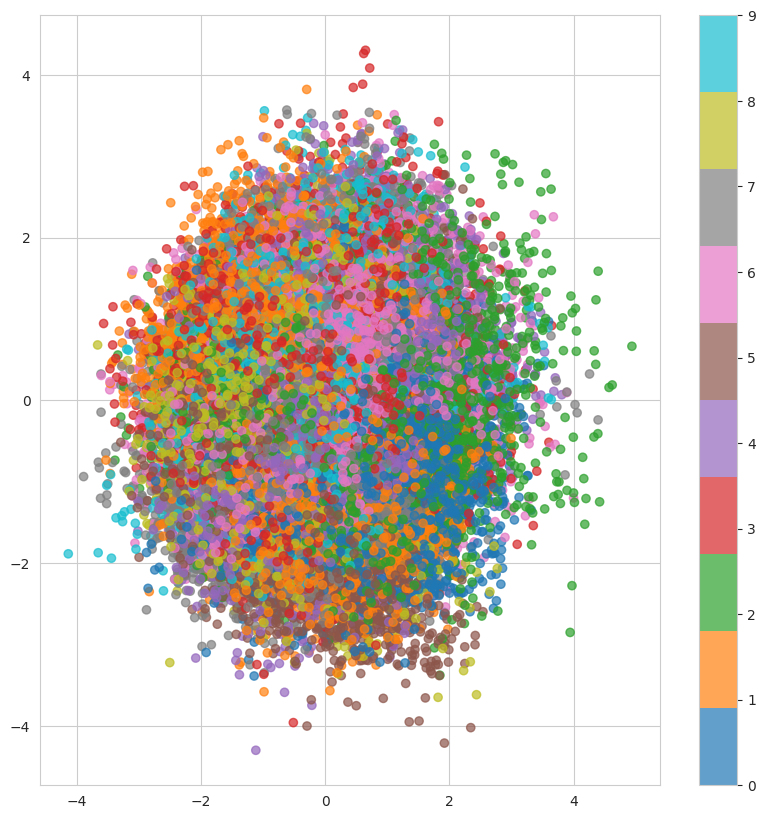

In [ ]:
plot_manifold(latents.reshape(-1, 2), labels=np.array(labels), alpha=0.7, classes=None)

In [ ]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)

steps = 10
space1 = torch.linspace(-3, 3, steps).to(device)
space2 = torch.linspace(-3, 3, steps).to(device)

grid = torch.cartesian_prod(space1, space2)

labels0 = torch.full((grid.shape[0],), 3).to(device)
with torch.no_grad():
    imgs = decoder(grid, torch.nn.functional.one_hot(labels0, num_classes=10)).cpu()

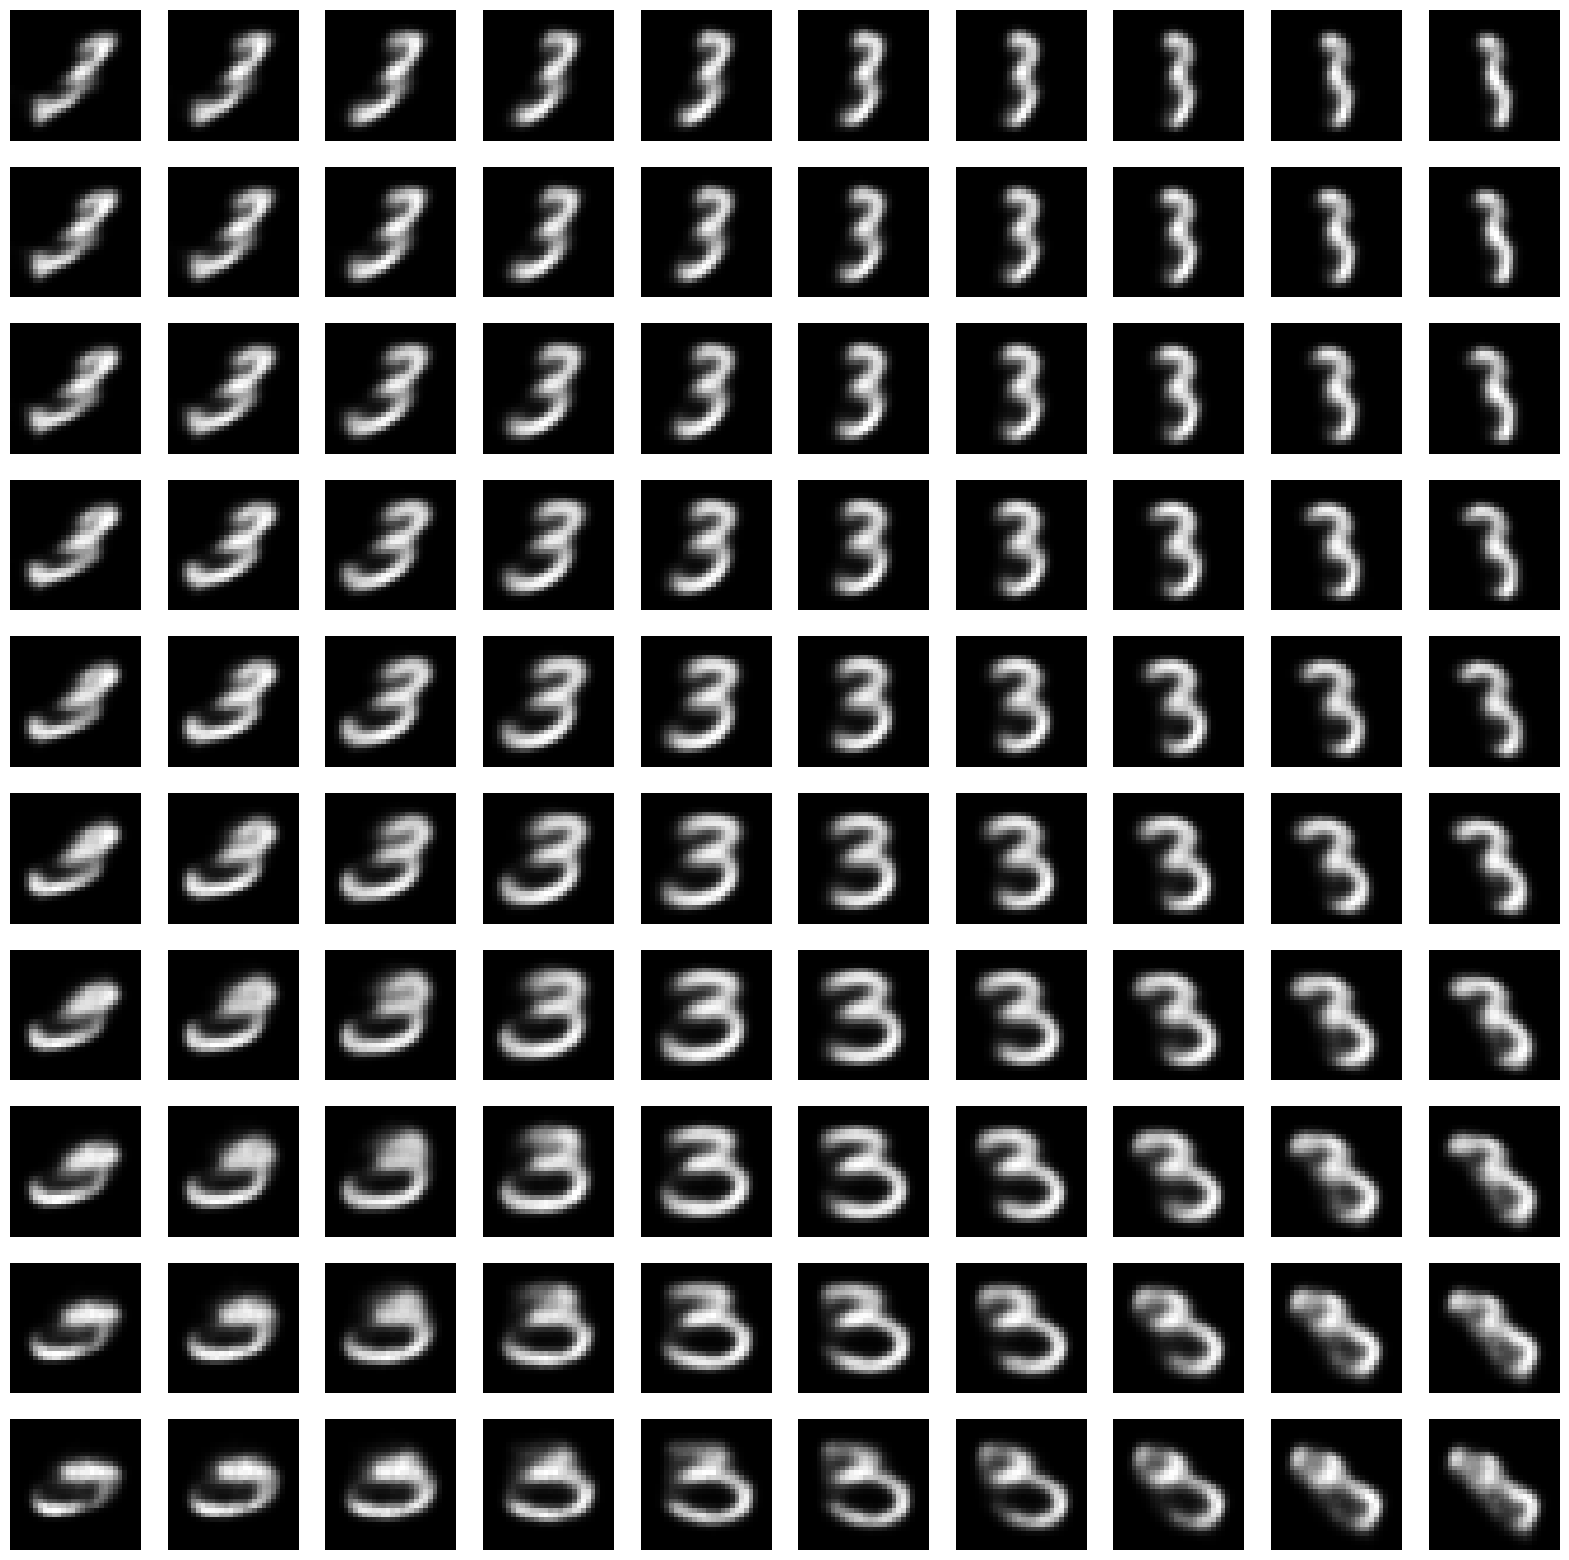

In [ ]:
def plot_samples(imgs, images_per_row=10):
    num_images = imgs.shape[0]
    rows = (num_images + images_per_row - 1) // images_per_row

    plt.figure(figsize=(images_per_row * 2, rows * 2))

    for i in range(num_images):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(imgs[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')

    plt.show()

plot_samples(imgs, images_per_row=10)

In [ ]:
from PIL import Image
from IPython.display import Image as iImage
# choose 1 batch of test loader
imgs, labels = next(iter(test_loader))
# select only samles with digit = 3
real_3 = imgs[labels == 3]

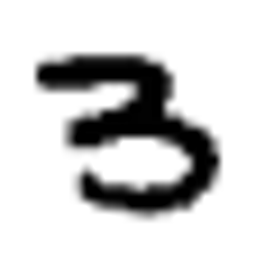

In [ ]:
size = (256, 256)
Image.fromarray(np.uint8(255 - np.squeeze(real_3[4:5].numpy()) * 255)).resize(size)

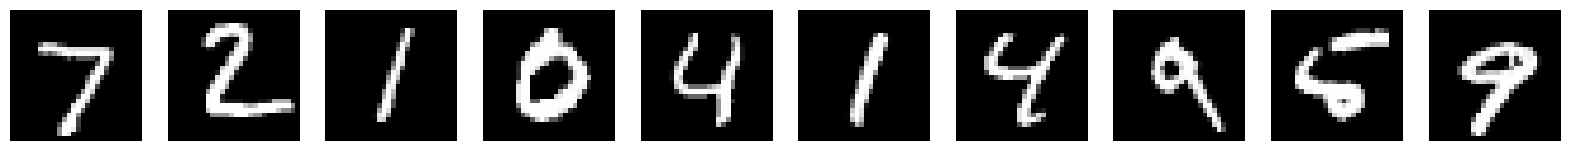

In [ ]:
def show_style(ds,digit_class='3',squeeze=True):
    fig, ax = plt.subplots(1, len(ds), figsize=(20, 5))
    for i in range(len(ds)):
      if squeeze==True:
          ax[i].imshow(ds[i].squeeze(0), cmap="Greys_r")
      else:ax[i].imshow(ds[i], cmap="Greys_r")
      ax[i].axis("off")
    plt.show()
# visualize the style of digits = 3
show_style(imgs[:10], digit_class='3')

Теперь вам нужно обработать ваши тройки энкодером и получить для них латентные представления, кодирующие стиль начертания. Далее в цикле по  i  от 0 до 9 подать в декодер латентные представления ваших троек и метку  i -той цифры.
Подсказка: вне цикла создайте пустой список images, а в цикле добавляйте в него результат работы декодера с  i -той цифрой.

In [ ]:
def show_generated_images(ds, num_images=10):
    fig, ax = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax[i].imshow(ds[i].squeeze(0), cmap="Greys_r")
        ax[i].axis("off")
    plt.show()

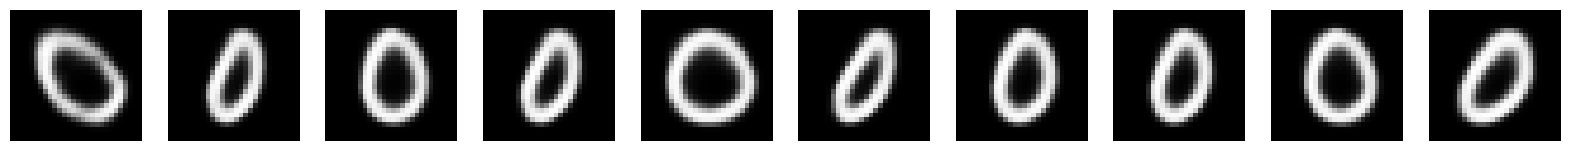

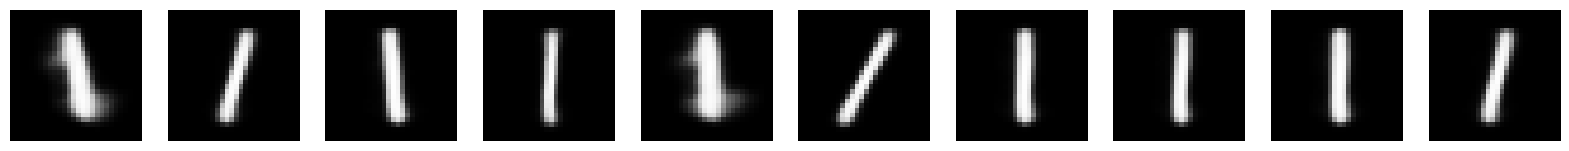

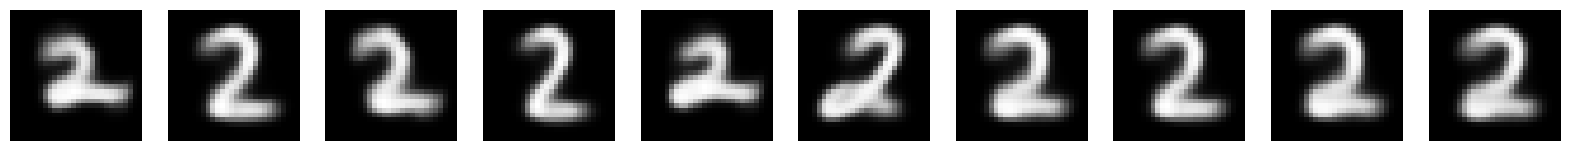

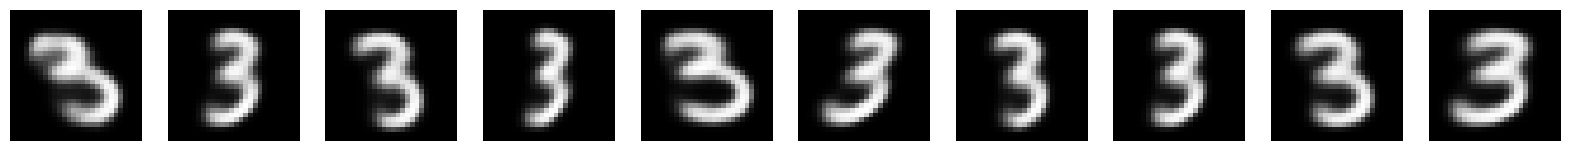

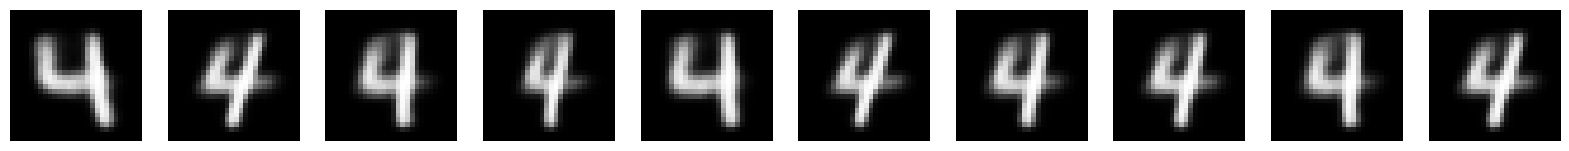

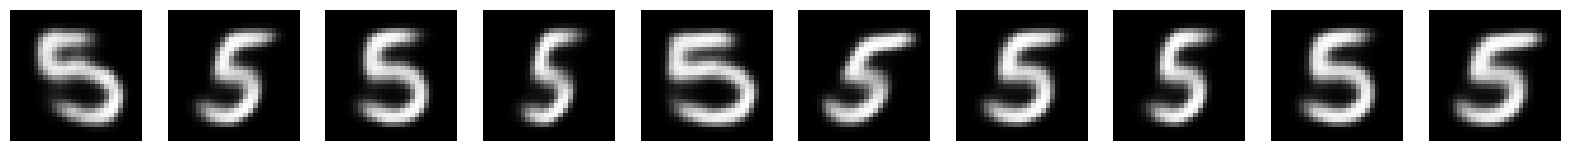

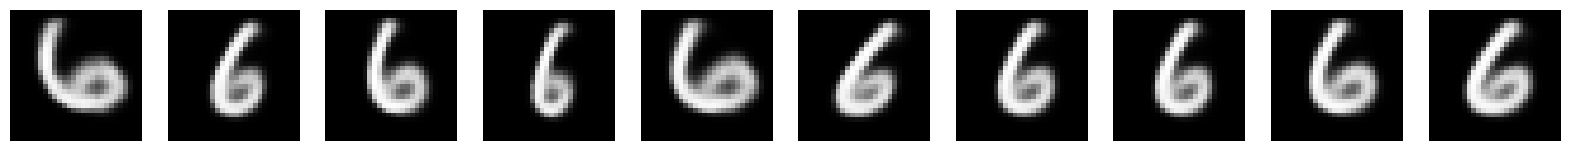

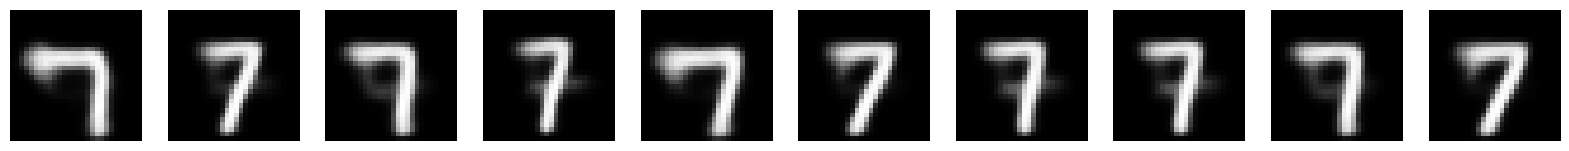

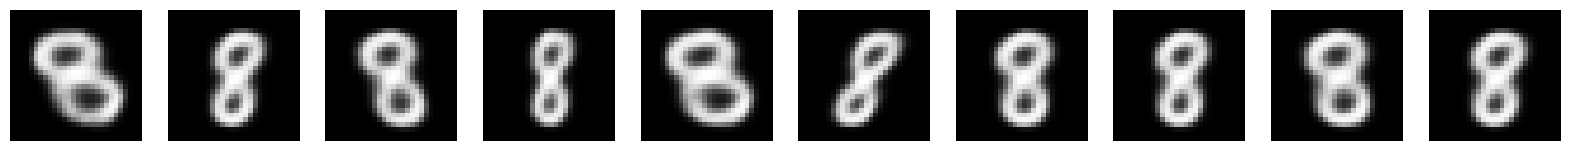

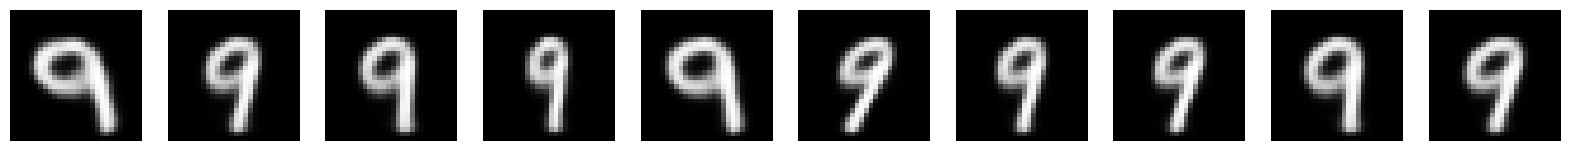

In [ ]:
images = []

for i in range(10):
    with torch.no_grad():
        label = torch.tensor([i] * real_3.size(0))
        _, generated_imgs = cvae_pass_handler(encoder, decoder, real_3.to(device), label)
        show_generated_images(generated_imgs)

## Формат результата


Визуализировать стиль тройки для других цифр

Пример визуализации стиля семерки:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX14/style_transfer.png" width="500">




# Задание 4. Детекция аномалий с помощью Autoencoder

Представим следующую ситуацию, нам нужна система, которая принимает изображение сетчатки глаза, если же изображение не является фотографией сетчатки глаза, то нам нужно сообщить пользователю об ошибке и не принимать это изображение.

Идея заключается в следующем: если автоэнкодер может выучить внутреннее представление данных,например фотографий сетчатки глаза, то при восстановлении данных, которые не являются фотографией сетчатки глаза, ошибка будет существенно больше. Установив порог этой ошибки мы сможем отделять нужные фотографии от не нужных.



*   Обучите автоэнкодер на фотографиях сетчатки глаза (RetinaMNIST)
*   Подайте в автоэнкодер другое изображение (можно взять BloodMNIST)
*   Посчитайте ошибку восстановления для разных датасетов
*   Установите порог (значение ошибки) для определения класса фотографии(сетчатка глаза или нет)
*   Проведите тесты
*   Напишите выводы



[MedMNIST](https://medmnist.com/) это набор медицинских датасетов по формату повторяющих MNIST:
   
*   размер изображений 28x28
*   соместимы с Pytorch([пример использования](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb))

Для начала работы необходимо истановить соответствующий пакет:




In [35]:
from IPython.display import clear_output

!pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git
clear_output()

Нам предлагают работать с двумя из них:

[RetinaMNIST](https://isbi.deepdr.org/data.html) и [BloodMNIST](https://www.researchgate.net/publication/340522931_A_dataset_of_microscopic_peripheral_blood_cell_images_for_development_of_automatic_recognition_systems)

Первый содержит изображения сетчатки глаз, второй клеток крови.

Using downloaded and verified file: /root/.medmnist/retinamnist.npz
Using downloaded and verified file: /root/.medmnist/retinamnist.npz


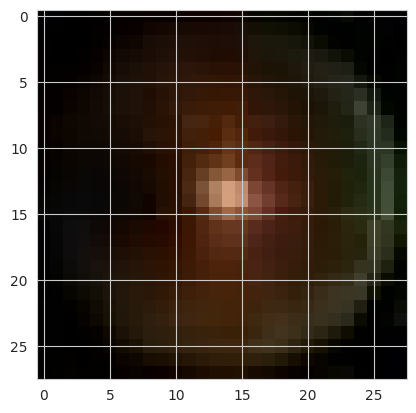

In [36]:
import medmnist
from medmnist import INFO  # , Evaluator
import matplotlib.pyplot as plt

DataClass = getattr(medmnist, INFO["retinamnist"]["python_class"])

train_retina_dataset = DataClass(split="train", download=True)
val_retina_dataset = DataClass(split="val", download=True)

plt.imshow(val_retina_dataset[0][0])

Несмотря на заявленную совместимость с Pytorch, у датасетов нет свойств `targets` и `data`

Но есть словарь `info`

https://github.com/MedMNIST/MedMNIST/blob/main/medmnist/dataset.py

In [37]:
info = val_retina_dataset.info
info

{'python_class': 'RetinaMNIST',
 'description': 'The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/retinamnist.npz?download=1',
 'MD5': 'bd4c0672f1bba3e3a89f0e4e876791e4',
 'url_64': 'https://zenodo.org/records/10519652/files/retinamnist_64.npz?download=1',
 'MD5_64': 'afda852cc34dcda56f86ad2b2457dbcc',
 'url_128': 'https://zenodo.org/records/10519652/files/retinamnist_128.npz?download=1',
 'MD5_128': 'e48e916a24454daf90583d4e6efb1a18',
 'url_224': 'https://zenodo.org/records/10519652/files/retinamnist_224.npz?download=1',
 'MD5_224': 'eae7e3b6f3fcbda4ae613ebdcbe35348',
 'task': 

В нем есть аналогичное `targets` свойство `labels`
В у самого объекта есть массив `imgs` аналогичный `data` в torchvision датасетах

In [38]:
print("labels", val_retina_dataset.labels.shape)
print("images", val_retina_dataset.imgs.shape)

labels (120, 1)
images (120, 28, 28, 3)


Можно используя эти свойства и сделать датасет совместимым с нашим кодом написанным для MNIST:

In [39]:
def cast2torch(ds):
    ds.targets = ds.labels
    ds.data = ds.imgs
    ds.classes = list(info["label"].values())


cast2torch(val_retina_dataset)
cast2torch(train_retina_dataset)

**RetinaMNIST classes**

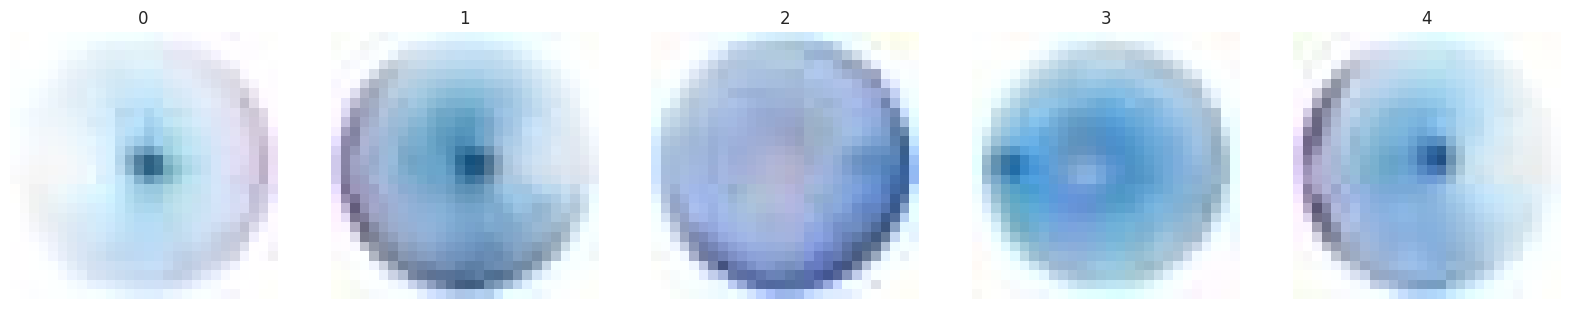

In [40]:
show_ds(val_retina_dataset)

Названий классов тут нет, но для нашей задачи они нам и не понадобятся.
Теперь загрузим датасет с клетками крови

In [41]:
DataClass = getattr(medmnist, INFO["bloodmnist"]["python_class"])
test_blood_dataset = DataClass(split="test", download=True)
cast2torch(test_blood_dataset)

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


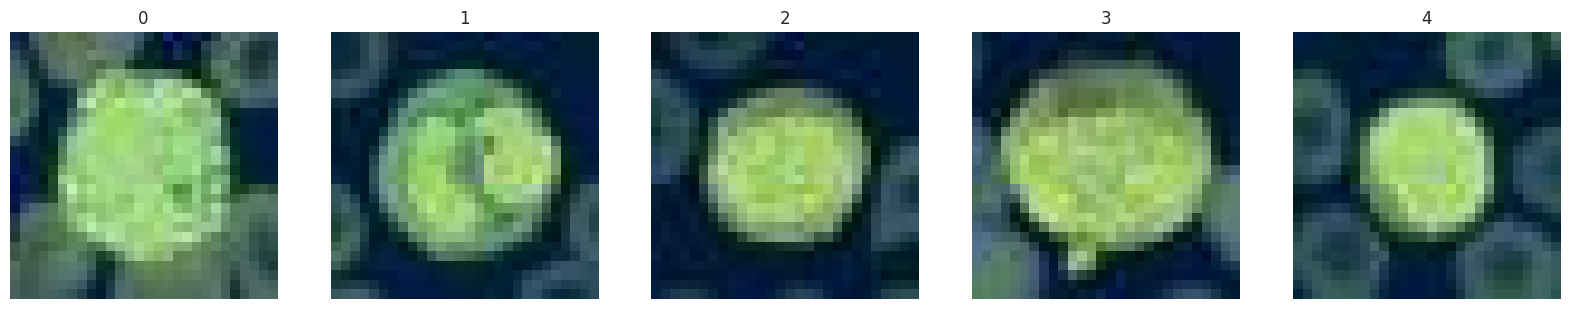

In [42]:
show_ds(test_blood_dataset)

По форме клетки крови отдаленно напоминают фото сетчатки.

Представим что при сборе новой порции данных, фотографии клеток крови по ошибке попали в папку с фото сетчатки и были включенны в новую версию датасета.

Нам надо исправить ошибку и отделить фото клеток сетчатки от фото клеток крови.

Для этого обучим автоэнкодер на той части датасета которая была собранна раньше и не содержит ошибок. Будем считать что это `train_retina_dataset` и `val_retina_dataset`

Обучим на них автоэнкодер. Для этого создадим загрузчики и добавим трансформации к датасетам. В частности сделаем изображения черно-белыми что бы использовать pipeline из предидущих заданий.

In [53]:
from torch.utils.data import DataLoader
from torchvision import transforms


data_transform = transforms.Compose(
    [
        # Convert all images to Grayscale fo sake of MNIST compatibility
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)

train_retina_dataset.transform = data_transform
val_retina_dataset.transform = data_transform
test_blood_dataset.transform = data_transform

# encapsulate data into dataloader form
train_loader = DataLoader(train_retina_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_retina_dataset, batch_size=1, shuffle=False)
blood_loader = DataLoader(test_blood_dataset, batch_size=1, shuffle=False)

In [54]:
def mse_loss_handler(data, recons, *args, **kwargs):
    return nn.MSELoss()(recons, data)

latent_size = 16
learning_rate = 0.001
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(42)

encoder = Encoder(latent_size).to(device)
decoder = Decoder(latent_size).to(device)

optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=learning_rate)

from torchsummary import summary
print('>>> Encoder')
print(summary(encoder, (1, 28, 28)))
print('>>> Decoder')
print(summary(decoder, (latent_size,)))

>>> Encoder
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
       BatchNorm2d-2           [-1, 32, 14, 14]              64
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,496
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
        LeakyReLU-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 512, 2, 2]         131,584
      BatchNorm2d-14       

In [61]:
for i in range(1,6):
    train(
        encoder=encoder,
        decoder=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=ae_pass_handler,
        loss_handler=mse_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/1080 (0%)]	Loss: 0.006867
Train Epoch: 2 [0/1080 (0%)]	Loss: 0.005269
Train Epoch: 3 [0/1080 (0%)]	Loss: 0.003675
Train Epoch: 4 [0/1080 (0%)]	Loss: 0.003767
Train Epoch: 5 [0/1080 (0%)]	Loss: 0.003416


In [64]:
def single_pass_handler(encoder, decoder, data, labels):
    latent_representation = encoder(data)
    reconstructed = decoder(latent_representation)
    return latent_representation, reconstructed

In [76]:
encoder.eval()
decoder.eval()
results5 = run_eval(encoder, decoder, val_loader, single_pass_handler)

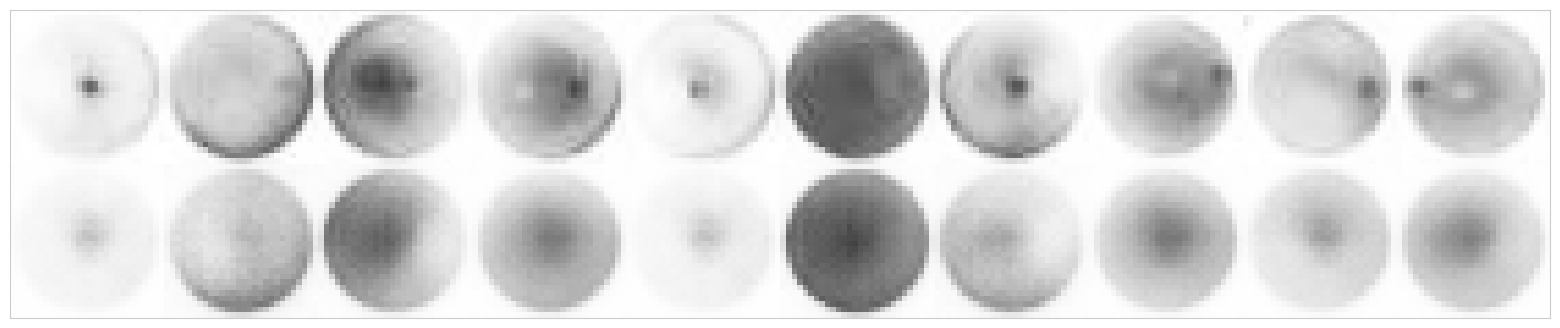

In [77]:
plot_samples(results5["real"][:10], results5["reconstr"][:10], invert_colors=True, digit_size=28, name=None)

Выведите среднюю ошибку mse восстановления для валидационных сэмплов:

In [78]:
mean_mse_retina = mse_loss_handler(torch.tensor(results5["real"]), torch.tensor(results5["reconstr"]))
print(f"MSE: {mean_mse_retina.item()}")

MSE: 0.0036971718072891235


Теперь посмотрим, что будет, если попытаться восстановить изображения клеток крови:

In [79]:
results6 = run_eval(encoder, decoder, blood_loader, single_pass_handler)
mean_mse_blood = mse_loss_handler(torch.tensor(results6["real"]), torch.tensor(results6["reconstr"]))
print(f"MSE: {mean_mse_blood.item()}")

MSE: 0.04314469173550606


Видно, что автоэнкодер пытается восстанавливать фотографии сетчатки и ошибка на порядок больше. Можно разделить фотографии по значению ошибки восстановления.

В качестве "испорченного датасета" возьмем val чаcть из RetinaMnist и test часть из BloodMnist.

In [82]:
mse_losses_retina = [
    mse_loss_handler(torch.tensor(results5["real"][i]), torch.tensor(results5["reconstr"][i])).item()
    for i in range(len(results5["real"]))
]

mse_losses_blood = [
    mse_loss_handler(torch.tensor(results6["real"][i]), torch.tensor(results6["reconstr"][i])).item()
    for i in range(len(results6["real"]))
]

mse_losses_retina = np.array(mse_losses_retina)
mse_losses_blood = np.array(mse_losses_blood)

In [84]:
threshold = (mean_mse_retina + mean_mse_blood) / 2
def classify_samples(mse_losses, threshold):
    return ["Retina" if loss < threshold else "Blood" for loss in mse_losses]

class_retina = classify_samples(mse_losses_retina, threshold)
class_blood = classify_samples(mse_losses_blood, threshold)
print("retina:", class_retina[:10])
print("blood:", class_blood[:10])

retina: ['Retina', 'Retina', 'Retina', 'Retina', 'Retina', 'Retina', 'Retina', 'Retina', 'Retina', 'Retina']
blood: ['Blood', 'Blood', 'Blood', 'Blood', 'Blood', 'Blood', 'Blood', 'Blood', 'Blood', 'Blood']


Постройте гистограммы ошибок mse_retina и mse_blood:

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

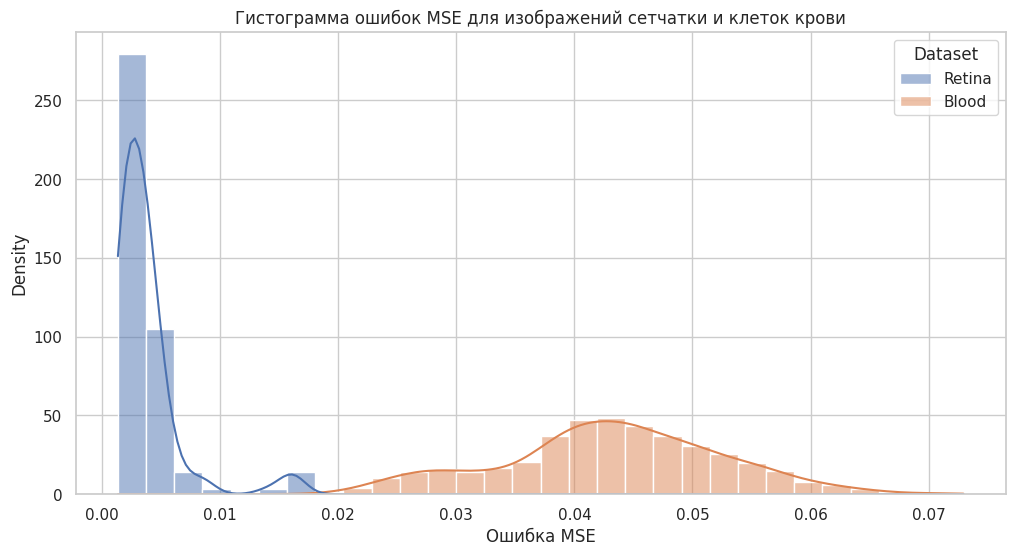

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mse_data = {
    'MSE': np.concatenate([mse_losses_retina, mse_losses_blood]),
    'Dataset': ['Retina'] * len(mse_losses_retina) + ['Blood'] * len(mse_losses_blood)
}

mse_df = pd.DataFrame(mse_data)

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(data=mse_df, x='MSE', hue='Dataset', bins=30, kde=True, stat="density", common_norm=False)

plt.title('Гистограмма ошибок MSE для изображений сетчатки и клеток крови')
plt.xlabel('Ошибка MSE')
plt.show()

Проанализируйте полученные гистограммы. Какой оптимальный порог mse нужен для выявления аномалии?

Можем взять среднее значение MSE для изображений сетчатки и клеток крови и установить порог между ними(threshold = (mean_mse_retina + mean_mse_blood) / 2).

## Формат результата

Получить значение качества модели, отделяющей изображение сетчатки глаза от других изображений для датасета MedMNIST.
Исходя из построенной гистограммы среднеквадратичной ошибки восстановления изображений, в качестве порога для детекции аномалий\различия клеток крови от сетчатки глаза вполне подойдет порог threshold = ...




